# Mamba MCMC for an LMM with one simple, scalar term

In [1]:
addprocs(4);
using Compat,GraphViz,Mamba,RDatasets

exception on 1: ERROR: opening file /home/juser/.julia/v0.3/Mamba/src/../usr/addons.jl: No such file or directory
 in open at ./iostream.jl:117
 in open at ./iostream.jl:135
 in readall at io.jl:247
 in anonymous at multi.jl:855
 in run_work_thunk at multi.jl:621
 in anonymous at task.jl:855
exception on 1: ERROR: opening file /home/juser/.julia/v0.3/Mamba/src/../usr/addons.jl: No such file or directory
 in open at ./iostream.jl:117
 in open at ./iostream.jl:135
 in readall at io.jl:247
 in anonymous at multi.jl:855
 in run_work_thunk at multi.jl:621
 in anonymous at task.jl:855
exception on 1: ERROR: opening file /home/juser/.julia/v0.3/Mamba/src/../usr/addons.jl: No such file or directory
 in open at ./iostream.jl:117
 in open at ./iostream.jl:135
 in readall at io.jl:247
 in anonymous at multi.jl:855
 in run_work_thunk at multi.jl:621
 in anonymous at task.jl:855
exception on 1: ERROR: opening file /home/juser/.julia/v0.3/Mamba/src/../usr/addons.jl: No such file or directory
 in ope

In [2]:
ds = dataset("lme4","Dyestuff");
dump(ds)

DataFrame  30 observations of 2 variables
  Batch: PooledDataArray{ASCIIString,Uint8,1}(30) ASCIIString["A","A","A","A"]
  Yield: DataArray{Int32,1}(30) Int32[1545,1440,1440,1520]


Create a `Dict{Symbol,Any}` containing the response and the indicator of the groups

In [11]:
dsdat = @compat Dict{Symbol,Any}(
  :y => convert(Vector{Float64},array(ds[:Yield])),
  :Zt => StatsBase.indicatormat(ds[:Batch]),
  :X => ones(30,1)
)
dsdat[:Zty] = dsdat[:Zt] * dsdat[:y]
dsdat[:Xty] = dsdat[:X]'dsdat[:y]

1-element Array{Float64,1}:
 45825.0

In [12]:
b = randn(6)
β = mean(dsdat[:y])

1527.5

In [13]:
dsdat[:X]*β + dsdat[:Zt]'b

30x1 Array{Float64,2}:
 1528.42
 1528.42
 1528.42
 1528.42
 1528.42
 1526.91
 1526.91
 1526.91
 1526.91
 1526.91
 1527.3 
 1527.3 
 1527.3 
    ⋮   
 1526.14
 1526.14
 1529.72
 1529.72
 1529.72
 1529.72
 1529.72
 1526.91
 1526.91
 1526.91
 1526.91
 1526.91

In [32]:
dsmod = Model(
  μ = Logical(1, @modelexpr(β,b,X,Zt,vec(X*β+Zt'b)), false),
  y = Stochastic(1, @modelexpr(μ,logσ,MvNormal(μ,exp(logσ))),false),
  logσ = Stochastic(1, :(Flat()), true),
  logσb = Stochastic(1, :(InverseGamma(0.001,0.001)), true),
  β = Stochastic(1, :(Flat()), true),
  b = Stochastic(1,@modelexpr(logσb,MvNormal(fill(6,exp(logσb)))),true)
);

In [33]:
draw(dsmod,filename="foo.dot");

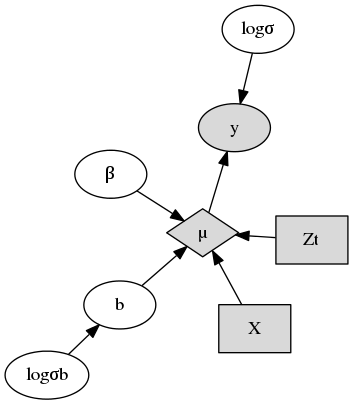

In [34]:
open("foo.dot","r") do io Graph(io) end

In [39]:
Gibbs_b = Sampler([:b],
@modelexpr(b,β,y,Zt,X,logσ,logσb,
begin
    I = eye(size(Zt,1))
    Λ = exp(logσb - logσ)*I
    ΛtZt = Λ'Zt
    L = cholfact(ΛtZt*ΛtZt' + I)
    rand(MvNormal(vec(L\(ΛtZt*(y-X*β)))))
end));    